<a href="https://colab.research.google.com/github/Germandev55/Topology_and_Geometry-for-Deep-Learning/blob/main/ID_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%%capture
import numpy as np
import math
import matplotlib.pyplot as plt

import IPython
from IPython.display import HTML
from google.colab import output

import tensorflow as tf
from keras.datasets import cifar10
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense, BatchNormalization, Dropout, Convolution2D, Input,Activation, ZeroPadding2D, MaxPooling2D, Flatten
from keras import regularizers

import sklearn
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn import manifold, datasets
from sklearn.manifold import TSNE
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import SpectralEmbedding
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import distance_matrix
from scipy.stats import pearsonr
from scipy.optimize import curve_fit
import random 

min_max_scaler = preprocessing.MinMaxScaler()
max_abs_scaler = preprocessing.MaxAbsScaler()
scaler = StandardScaler()
  
!pip install ripser
from ripser import ripser
from ripser import Rips

In [3]:
%%capture
!pip install fermat
!pip install scikit-dimension
from fermat import Fermat
import skdim
from scipy.interpolate import make_interp_spline
import pickle

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
# Conver and normalize images [0..255] --> [0..1]
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
# Standarize Images центрирование по каждому каналу 
mean = np.mean(x_train,axis=(0, 1, 2, 3))
std = np.std(x_train,axis=(0, 1, 2, 3)) # стандартное отклонение
x_train = (x_train-mean)/(std + 1e-7)
x_test = (x_test-mean)/(std + 1e-7)

170508288/170498071 [==============================] - 4s 0us/step


## Вспомогательные функции

In [5]:
def features_to_X(x_data, model, index_layer):
  input = x_data
  layer = model.get_layer(index=index_layer) 
  #print(layer)
  #layer_name = str(layer).split('.')[5].split(' ')[0]
  #layer_name = layer
  features_layer1 = tf.keras.models.Model(inputs=model.inputs, outputs = layer.output)
  output_ = features_layer1(input) 
  try:
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    #global_average_layer = tf.keras.layers.Flatten()
    #global_average_layer  = tf.keras.layers.MaxPooling2D(pool_size=(4, 4), strides=None, 
    #padding="valid", data_format=None)

    feature_batch_average = global_average_layer(output_)
    X = feature_batch_average
    #X = np.reshape(X,(X.shape[0], -1))
  except:
    X = output_ 
  #X = features_layer1.predict(input)  
  return X, layer

def get_Betti(data, eps, maxdim=1):
  Betti_layer = []
  dgms = ripser(data, maxdim=maxdim, thresh=eps)['dgms']  
  inf_in_list = lambda x: 1 if np.isinf(x).any() else 0
  Betti_list = [0,0,0]
  for e, i in enumerate(dgms):
    for x in i: Betti_list[e] += inf_in_list(x)
  return sum(Betti_list)

def get_Betti_prob(data, eps, alpha, maxdim=2):
  dgms = ripser(data, maxdim=maxdim, thresh=eps)['dgms']  
  prev_max = 0
  list_Hom = []
  mean_Hom = []
  for Hom in dgms:
    B_Hom = 0
    for i in Hom:   
      if (np.isinf(i).any() == False):
        B_Hom += (((i[1]-i[0]))**alpha)*0.5
        prev_max = i[1]
      else:
        #в случае infinity прибавляем последнее время жизни
        continue
        B_Hom += prev_max 

    list_Hom.append(B_Hom)
    l = len(Hom)
    if len(Hom) == 0: l=1
    mean_Hom.append(B_Hom/l)

  mean_Hom =  [round(x,3) for x in mean_Hom]
  return list_Hom, mean_Hom

In [6]:
def compute_MGST(X, hom_dim) -> float:
  MGST, _ = get_Betti_prob(X, eps=np.inf, alpha=1, maxdim=hom_dim)
  lfts = round(MGST[hom_dim], 3)
  return lfts

def MGST_layers(model, examples, layers, hom_dim, fermat_alpha, n_class=1, mode = 'local') -> list:
  class_ = n_class
  MGST_layers_list = []
  for lr in layers:
    X_emb, layer_name = features_to_X(x_train[:examples], model, index_layer=lr) 
    print(layer_name, X_emb.shape)
    X_emb = min_max_scaler.fit_transform(X_emb)   
      
    if mode == 'local':
      X_emb_class = []
      for e, i in enumerate(y_train[:examples]):
        if i == class_: X_emb_class.append(X_emb[e])
      Xtest_class = np.array(X_emb_class)
    else:
      Xtest_class = np.array(X_emb)

    MGST_ = compute_MGST_Fermat(Xtest_class, hom_dim, fermat_alpha)
    #MGST_ = get_Betti(Xtest_class, eps=eps, maxdim=0)

    print(f'{lr}) {MGST_}')
    MGST_layers_list.append(MGST_)
  
  return MGST_layers_list

def compute_MGST_Fermat(X, hom_dim, fermat_alpha) -> float:
  distances_X = distance_matrix(X, X)
  f_exact = Fermat(fermat_alpha, path_method='FW') 
  f_exact.fit(np.matrix(distances_X))
  fermat_dist_exact = f_exact.get_distances()
  MGST, _ = get_Betti_prob(fermat_dist_exact, eps=np.inf, alpha=1, maxdim=hom_dim)
  lfts = round(MGST[hom_dim], 3)
  return lfts

In [159]:
def power_law(x, a, b):
    return a*np.power(x, b)

def PHdim(X, hom_dim, n, alpha=1):
  n = 500
  n_array = []
  MGST_array = []
  while X.shape[0] > n:
    MGST, _ = get_Betti_prob(X[:n,:], np.inf, alpha, hom_dim)
    MGST_array.append(MGST[hom_dim])

    #MGST = compute_MGST_Fermat(X[:n,:], 0, 1)
    #MGST_array.append(MGST)
    n_array.append(n)
    n += 250

  x = np.array(n_array).reshape((-1, 1))
  y = np.array(MGST_array)
  model = LinearRegression().fit(np.log(x), np.log(y))
  pars, pcov = curve_fit(power_law,  np.array(n_array),y)
  #y = b0+b1*x
  b1 = model.coef_[0]
  b0 = model.intercept_
  r_sq = model.score(x, y)
  betta = math.log((sum(MGST_array)/len(MGST_array)))/math.log(n_array[-1])
  #d = alpha/(1-betta) #(не работает)
  #d = -1/(b1-1)
  #d = -1/(pars[1]-1)
  d = 1/(1-b1)
  return round(d,2)
#log(MGST) = a*log(n) + b + eps, α = (m − γ)/m

In [34]:
def PHDim_layers(model, data, layers, hom_dim, alpha):
  class_ = 1
  examples = 500
  PHDim_layers_list = []
  #layers_check = layers
  SVDDim_layers_list = []
  for lr in layers:
    X_emb, layer_name = features_to_X(data, model, index_layer=lr) 
    #print(layer_name, X_emb.shape)
    #X_emb = min_max_scaler.fit_transform(X_emb)
    
    X_emb_class = []
    for e, i in enumerate(y_train[:examples]):
      if i == class_: X_emb_class.append(X_emb[e])
    X_emb_class = np.array(X_emb_class)

    X_emb_class = np.array(X_emb)
    PHdim_ = PHdim(X_emb_class, hom_dim = hom_dim, n = X_emb_class.shape[0], alpha=alpha)
  
    print(f'{lr}) {PHdim_}')
    PHDim_layers_list.append(PHdim_)
  return PHDim_layers_list
  
def unistscount(layer_list: list) -> list:
  return [round((e+1)/len(layer_list),2) for e,i in enumerate(layer_list)]

def cocycles():
  ripser(x_train[:1000].reshape((1000, 32*32*3)), maxdim=1, thresh=np.inf, do_cocycles=True)['cocycles'] 

In [9]:
from math import sqrt
def estimate_ID(X, fraction=0.9):            
    # sort distance matrix
    Y = np.sort(X,axis=1,kind='quicksort')
    # clean data
    k1 = Y[:,1]
    k2 = Y[:,2]

    zeros = np.where(k1 == 0)[0]
    degeneracies = np.where(k1 == k2)[0]
    good = np.setdiff1d(np.arange(Y.shape[0]), np.array(zeros) )
    good = np.setdiff1d(good,np.array(degeneracies))

    k1 = k1[good]
    k2 = k2[good]    
    
    # n.of points to consider for the linear regression
    npoints = int(np.floor(good.shape[0]*fraction))

    # define mu and Femp
    N = good.shape[0]
    mu = np.sort(np.divide(k2, k1), axis=None,kind='quicksort')
    Femp = (np.arange(1,N+1,dtype=np.float64) )/N
    
    # take logs (leave out the last element because 1-Femp is zero there)
    x = np.log(mu[:-2])
    y = -np.log(1 - Femp[:-2])

    # regression
    regr = linear_model.LinearRegression(fit_intercept=False)
    regr.fit(x[0:npoints,np.newaxis],y[0:npoints,np.newaxis]) 
    r,pval = pearsonr(x[0:npoints], y[0:npoints])  
    return x,y,regr.coef_[0][0],r,pval

def estimate_ID_layers(model,data,layers_list):
    list_ID = []
    for lr in layers_list:
      X_emb, layer_name = features_to_X(data, model, index_layer=lr) 
      distances_X = distance_matrix(X_emb, X_emb)
      ID = estimate_ID(distances_X, fraction=1.0)
      list_ID.append(round(ID[2], 2))
    return list_ID

In [10]:
def PH_complexity(data, eps, maxdim=2):
  eps = 0.00005
  dgms = ripser(data, maxdim=maxdim, thresh=np.inf)['dgms']  
  for Hom in dgms:
    count_list = []
    eps_list = []
    count = 0
    while eps < 0.5:
      for i in Hom:   
        if np.isinf(i).any() == False:
          if (i[1] - i[0]) > eps:
            count += 1
        else:
          continue
      #count_value = count
      eps = eps + 0.00001
      count_list.append(count)
      eps_list.append(eps)
  
  fig, ax = plt.subplots(figsize=(3, 3))
  plt.plot(count_list, eps_list, 'o-',  linewidth=0.7)
  plt.show()
  
  #return PH_comp

# Эксперименты

In [ ]:
import tensorflow_datasets as tfds
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
#(x_train, y_train), (x_test, y_test) = tf.keras.datasets.svhn_cropped.load_data()
# Conver and normalize images [0..255] --> [0..1]
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [153]:
from PIL import Image

path_of_dir_spoof = '/content/drive/MyDrive/dataset_spoofing/spoof/'
path_of_dir_real = '/content/drive/MyDrive/dataset_spoofing/real/'
path_ = path_of_dir_real
basepath = Path(path_)
from os import listdir

from matplotlib import image
c = 0
loaded_images = list()
for filename in listdir(basepath):
  c = c + 1
  image = Image.open(path_ + filename)
  new_image = image.resize((64, 64))
  pic = np.array(new_image)
  loaded_images.append(pic)
  if c == 2000: 
    break

In [ ]:
pickleFile = open("/content/drive/MyDrive/Paper_Topol_DL/spoof_images.pkl", 'wb')
pickle.dump(loaded_images, pickleFile)
pickleFile.close()

In [116]:
from pathlib import Path
path_of_dir_real = '/content/drive/MyDrive/dataset_spoofing/real/'
path_ = path_of_dir_real
basepath = Path(path_)
from os import listdir
from matplotlib import image

id_list = []
loaded_images = list()
class_list = [0,47,40,3,12,99,53,48,116,115]
X_train_face = []
y_train_labels = []
for filename in listdir(basepath):
  c = c + 1
  splitted = filename.split('_')[1]
  id = splitted.partition('id')[2]
  id = int(id)
  if id in class_list:
    image = Image.open(path_ + filename)
    new_image = image.resize((64, 64))
    pic = np.array(new_image)
    X_train_face.append(pic)
    y_train_labels.append(class_list.index(id))
  if c == 1600: 
    break

In [117]:
face_dataset = [X_train_face,y_train_labels]

In [118]:
pickleFile = open("/content/drive/MyDrive/Paper_Topol_DL/face_dataset.pkl", 'wb')
pickle.dump(face_dataset, pickleFile)
pickleFile.close()

In [ ]:
for i in y_train_labels:
  print(i)

In [114]:
source = []
for e, i in enumerate(y_train_labels):
  if i == 9: source.append(X_train_face[e])

In [ ]:
fig, ax = plt.subplots()


for i in source:
  ax.imshow(i)
plt.show()

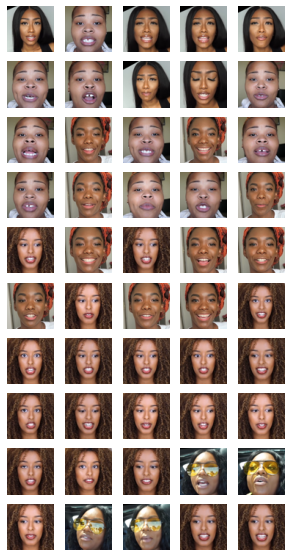

In [172]:
r, c = 10, 5
source = real_64
fig, axs = plt.subplots(r, c, figsize=(c, r))
cnt = 0
for i in range(r):
    for j in range(c):
        img = tf.keras.preprocessing.image.array_to_img(source[cnt])
        axs[i,j].imshow(img, cmap='gray')
        #axs[i,j].imshow(gen_imgs1[cnt, :,:,0])#, cmap='gray')
        axs[i,j].axis('off')
        cnt += 1
plt.show()
plt.close()

In [66]:
from collections import Counter
count =  Counter(id_list)

In [68]:
import collections
sorted_dict = collections.OrderedDict(count)

In [75]:
import operator
id_dict = sorted_x = sorted(count.items(), key=operator.itemgetter(1))

In [ ]:
id_dict

In [ ]:
r, c = 25, 25
source = nploaded_images #loaded_images
fig, axs = plt.subplots(r, c, figsize=(c, r))
cnt = 0
for i in range(r):
    for j in range(c):
        img = tf.keras.preprocessing.image.array_to_img(source[cnt])
        axs[i,j].imshow(img, cmap='gray')
        #axs[i,j].imshow(gen_imgs1[cnt, :,:,0])#, cmap='gray')
        axs[i,j].axis('off')
        cnt += 1
plt.show()
plt.close()

In [11]:
images_numbers = 1628
f =  open('/content/drive/MyDrive/Paper_Topol_DL/real_images.pkl', 'rb')
real_imgs = pickle.load(f)
real_imgs = np.array(real_imgs)
real_dataset  = real_imgs.reshape((images_numbers, 224*224*3))

f =  open('/content/drive/MyDrive/Paper_Topol_DL/spoof_images.pkl', 'rb')
spoof_imgs = pickle.load(f)
spoof_imgs = np.array(spoof_imgs[:images_numbers])
spoof_dataset = spoof_imgs.reshape((images_numbers, 224*224*3))

In [42]:
from matplotlib import image
from PIL import Image
c = 0
spoof_112 = list()
for img in spoof_imgs:
  PIL_image = Image.fromarray(img.astype('uint8'), 'RGB')
  new_image = PIL_image.resize((112, 112))
  pic = np.array(new_image)
  spoof_112.append(pic)

In [18]:
#data_images = spoof_imgs.reshape((images_numbers, 224*224*3))
PHdim_data_mnist = PHdim(real_dataset, hom_dim = 0, n = images_numbers, alpha=1)
print('PHdim = ', round(PHdim_data_mnist, 2))

PHdim =  5.95


In [22]:
from sklearn.decomposition import PCA
pca = PCA(0.9) 
pca_result = pca.fit_transform(real_dataset)

In [ ]:
pca_result

In [12]:
spoof_real = np.concatenate((spoof_dataset, real_dataset), axis=0)

In [ ]:
distances_X = distance_matrix(loaded_images1, loaded_images1)
ID = estimate_ID(distances_X, fraction=1.0)
print('ID = ',round(ID[2], 2))

ID =  5.73


In [ ]:
import skdim
lpca = skdim.id.CorrInt(k1=10, k2=20, DM=False)
id_corr = lpca.fit_transform(loaded_images1)
print(id_corr)

5.506997616531312


In [ ]:

f =  open('/content/drive/MyDrive/Paper_Topol_DL/conv110_mnist_dim25.pkl', 'rb')
mnist_generated = pickle.load(f)

In [ ]:
examples = 12000

data_mnist = mnist_generated[:examples].reshape((examples, 28*28))
PHdim_data_mnist = PHdim(data_mnist, hom_dim = 0, n = data_mnist.shape[0], alpha=1)
print('PHdim = ',round(PHdim_data_mnist, 2))
distances_X = distance_matrix(data_mnist, data_mnist)
ID = estimate_ID(distances_X, fraction=1.0)
print('ID = ',round(ID[2], 2))

PHdim =  16.92
ID =  19.15


In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
rec_error =  np.array([0.0133,0.0169,0.0211,0.0228,0.0235,0.0250,0.0256])
#intrisinc_dim_labels = ['7(7.38)','10(11.12)','15(15.17','18(16.37)','25(19.15)','40(23.11)','80(26.25)']
intrisinc_dim =  np.array([7.38, 11.12, 15.17, 16.37, 19.15, 23.11, 26.25])
X_Y_Spline = make_interp_spline(rec_error, intrisinc_dim)
X_rec_error = np.linspace(rec_error.min(), rec_error.max(), 50)
Y_intrisinc_dim = X_Y_Spline(X_rec_error)

plt.plot(X_rec_error, Y_intrisinc_dim, linewidth=1.7, markersize=2)
ax.grid(which='major', color='#CCCCCC', linestyle='--', alpha=0.35)
ax.set_yticklabels(intrisinc_dim,rotation=10)
ax.set_yticks(intrisinc_dim)
ax.set_yticklabels(intrisinc_dim_labels)
plt.title('influence dimension of synthetic data to reconstruction ability of autoencoder')
plt.xlabel("Reconstruction error")
plt.ylabel("Instrisinc dimenstion")
plt.show()

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()
# Conver and normalize images [0..255] --> [0..1]
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

169017344/169001437 [==============================] - 4s 0us/step


In [ ]:
mu, sigma = 0, 1  
noise = np.random.normal(size=(12000, 30)) 

In [ ]:
d = np.concatenate((noise, data_mnist),axis=1)

In [ ]:
fashion_mnist 3000 = 10.41, 12000 = 14.18
mnist 3000 = 23.16, 12000 = 18.39    
orig_mnist_5 = 22.75 / gen_mnist_5(15) = 15.62 / gen_mnist_5(80) = 27 / gen_mnist_5(3) = 3.83
mnist(10) 12000 = 11.84 
mnist(40) 12000 = 17.96
mnist(50) 12000 = 21.65
cifar10 3000 = 23.38, 12000 = 26,54
cifar100 3000 = 24.38, 12000 = 24.44

In [ ]:
(X_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
сlass_ = 5
X_emb = X_train
X_emb_class = []
for e, i in enumerate(y_train):
  if i == сlass_: X_emb_class.append(X_emb[e])
Xtest_class = np.array(X_emb_class)

In [ ]:
data_cifar10 = x_train[:examples].reshape((examples, 32*32*3))
PHdim_cifar10 = PHdim(data_cifar10, hom_dim = 0, n = data_cifar10.shape[0], alpha=1)
#distances_X = distance_matrix(data_cifar10, data_cifar10)
#ID = estimate_ID(distances_X, fraction=1.0)
print(round(PHdim_cifar10, 2))

In [124]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer
from tensorflow.keras import regularizers
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import Input, MaxPooling2D, Dropout, Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

weight_decay = 1e-4
class ArcFace(tf.keras.layers.Layer):
    def __init__(self, n_classes=10, s=30.0, m=0.50):
        super(ArcFace, self).__init__()
        self.n_classes = n_classes
        self.s = s
        self.m = m

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'n_classes': self.n_classes,
            's': self.s,
            'm': self.m
        })
        return config


    def build(self, input_shape):
        super(ArcFace, self).build(input_shape[0])
        self.W = self.add_weight(name='W',
                                shape=(input_shape[0][-1], self.n_classes),
                                initializer='glorot_uniform',
                                trainable=True,
                                regularizer=regularizers.l2(1e-4))
    def call(self, inputs):
        x, y = inputs
        c = K.shape(x)[-1]
        # normalize feature
        x = tf.nn.l2_normalize(x, axis=1)
        # normalize weights
        W = tf.nn.l2_normalize(self.W, axis=0)
        # dot product
        logits = x @ W
        # add margin
        # clip logits to prevent zero division when backward
        theta = tf.acos(K.clip(logits, -1.0 + K.epsilon(), 1.0 - K.epsilon()))
        target_logits = tf.cos(theta + self.m)
        # sin = tf.sqrt(1 - logits**2)
        # cos_m = tf.cos(logits)
        # sin_m = tf.sin(logits)
        # target_logits = logits * cos_m - sin * sin_m
        #
        logits = logits * (1 - y) + target_logits * y
        # feature re-scale
        logits *= self.s
        out = tf.nn.softmax(logits)

        return out
    
    @tf.function
    def compute_output_shape(self, input_shape):
        return (None, self.n_classes)

def vgg_block(x, filters, layers):
    for _ in range(layers):
        x = Convolution2D(filters, (3, 3), padding='same', kernel_initializer='he_normal',
                    kernel_regularizer=regularizers.l2(weight_decay))(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

    return x

def vgg8_arcface(name='arcface'):
    input = Input(shape=(64, 64, 3))
    y = Input(shape=(10,))
    width = 32
    x = vgg_block(input, width, 1)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = vgg_block(x, width, 1)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = vgg_block(x, width, 1)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = vgg_block(x, width, 1)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = vgg_block(x, width, 1)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = vgg_block(x, width, 1)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Flatten()(x)
    x = Dense(128, kernel_initializer='he_normal',
                kernel_regularizer=regularizers.l2(weight_decay))(x)
    x = BatchNormalization()(x)
    output = ArcFace()([x, y])

    return keras.Model([input, y], output, name=name)

model = vgg8_arcface('vgg_arcface_face')

In [125]:
model.load_weights('/content/drive/MyDrive/dataset_spoofing/arcface_vgg32.h5')

In [ ]:
arcface_vgg32 = keras.models.load_model('/content/drive/MyDrive/dataset_spoofing/arcface_vgg32.h5')

In [160]:
arcface_vgg32.layers

In [ ]:
elist = []
for e, layer in enumerate(arcface_vgg32.layers[:-1]):
  print(layer)
  layer_name = str(layer).split('.')[3].split(' ')[0]
  if (str('Conv') in layer_name): 
    elist.append(e)
print(elist)

In [155]:
pickleFile = open("/content/drive/MyDrive/Paper_Topol_DL/spoof_real_64.pkl", 'wb')
dataset = [real_64 + spoof_64[:len(real_64)]]
pickle.dump(dataset , pickleFile)
pickleFile.close()

In [154]:
real_64 = np.array(loaded_images)

In [140]:
spoof_64 = np.array(loaded_images)

In [34]:
real_112x112   = real_112_.reshape((images_numbers, 112*112*3))

In [146]:
y_train = [1]*510

In [ ]:
list(range(1,24))

In [167]:
examples = 1600
y_train_ = tf.keras.utils.to_categorical([1]*examples, 10)
PHdim_arcface_vgg32 = PHDim_layers(arcface_vgg32, (real_64[:examples],y_train_), [1,4,8,12,16,20,24,-3], 0, alpha=1)

1) 2.73
4) 3.41
8) 3.49
12) 3.74
16) 4.1
20) 4.45
24) 4.49
-3) 4.47


In [168]:
print(PHdim_arcface_vgg32)

[2.73, 3.41, 3.49, 3.74, 4.1, 4.45, 4.49, 4.47]


In [ ]:
PHDim_layers_list = []
model_layers = [ 8, 16,32, 48,61, 75, 86, 92,104, 117,122,136, 142,161]
#[15, 24, 33, 44, 53, 62, 71, 82, 91, 100, 109, 118, 127, 138, 147, 156]
# spoof_112_
for lr in model_layers:
  X_emb, layer_name = features_to_X(real_112_[:650], Resnet_34, index_layer=lr)    
  X_emb_class = np.array(X_emb)
  distances_X = distance_matrix(X_emb_class, X_emb_class)
  ID1 = estimate_ID(distances_X, fraction=1.0)
  ID = round(ID1[2], 2)
  print(f'{lr}) {ID}')
  PHDim_layers_list.append(ID)
  

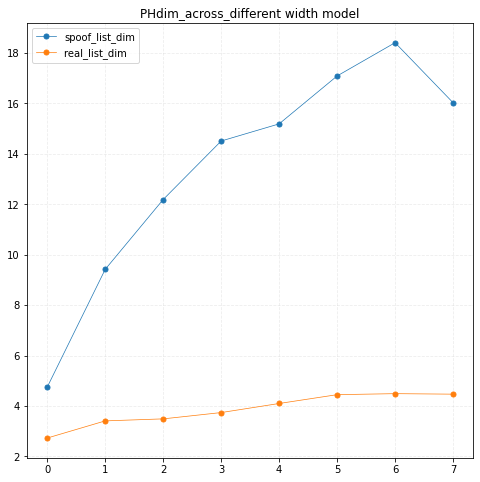

In [169]:
fig, ax = plt.subplots(figsize=(8, 8))
spoof_list_dim = [4.75, 9.42, 12.19, 14.51, 15.19, 17.09, 18.41, 16.03]
real_list_dim = [2.73, 3.41, 3.49, 3.74, 4.1, 4.45, 4.49, 4.47] 
plt.plot(range(len(spoof_list_dim)), spoof_list_dim, 'o-',  linewidth=0.7, markersize=5, label='spoof_list_dim')
plt.plot(range(len(real_list_dim )), real_list_dim , 'o-',  linewidth=0.7, markersize=5, label='real_list_dim ')
ax.grid(which='major', color='#CCCCCC', linestyle='--', alpha=0.35)
plt.legend()
plt.title('PHdim_across_different width model')
plt.show()

In [ ]:
# ИЗМЕНЕНИЕ PHdim ПО СЛОЯМ У МОДЕЛИ С РАЗНОЙ ШИРИНОЙ СЛОЁВ
%%capture
examples = 2000
PHdim_Resnet_6_96 = [22] + PHDim_layers(Resnet_6_96, x_train[:examples], [14, 27, 49, 71, 93, 115, -2, -1], 0, alpha=1)
PHdim_Resnet_6_64 = [22] + PHDim_layers(Resnet_6_64, x_train[:examples], [14, 27, 49, 71, 93, 115, -2, -1], 0, alpha=1)
PHdim_Resnet_6_32 = [22] + PHDim_layers(Resnet_6_32, x_train[:examples], [14, 27, 49, 71, 93, 115, -2, -1], 0, alpha=1)
PHdim_Resnet_6_20 = [22] + PHDim_layers(Resnet_6_20, x_train[:examples], [14, 27, 49, 71, 93, 115, -2, -1], 0, alpha=1)
PHdim_Resnet_6_256 = [22] + PHDim_layers(Resnet_6_256, x_train[:examples], [14, 27, 49, 71, 93, 115, -2, -1], 0, alpha=1)
PHdim_Resnet_6_128 = [22] + PHDim_layers(Resnet_6, x_train[:examples], [14, 27, 49, 71, 93, 115, -2, -1], 0, alpha=1)
PHdim_Resnet_6_352 = [22] + PHDim_layers(Resnet_6_352, x_train[:examples], [14, 27, 49, 71, 93, 115, -2, -1], 0, alpha=1)
PHdim_Resnet_6_412 = [22] + PHDim_layers(Resnet_6_412, x_train[:examples], [14, 27, 49, 71, 93, 115, -2, -1], 0, alpha=1)
PHdim_Resnet_6_512 = [22] + PHDim_layers(Resnet_6_512, x_train[:examples], [14, 27, 49, 71, 93, 115, -2, -1], 0, alpha=1)

In [ ]:
PHdim(X_emb_class, hom_dim = hom_dim, n = X_emb_class.shape[0], alpha=alpha)

In [ ]:
data_cifar10 = x_train[:examples].reshape((examples, 32*32*3))
PHdim_cifar10 = PHdim(data_cifar10, hom_dim = 0, n = data_cifar10.shape[0], alpha=1)
#distances_X = distance_matrix(data_cifar10, data_cifar10)
#ID = estimate_ID(distances_X, fraction=1.0)
print(round(PHdim_cifar10, 2))

22.81


In [ ]:
%%capture
layers_check =  [1, 5, 10, 15, 20, 25, -2, -1] #[14, 27, 49, 71, 93, 115, -2, -1]
PHdim_cifar10 = [22]
examples = 2000
PHdim_models_diff_width = []
model_list = VGG_diff_width
for model in model_list:
  PHdim_models_diff_width.append(PHdim_cifar10 + PHDim_layers(model, x_train[:examples], layers_check, 0, alpha=1))
  #PHdim_Resnet_diff_width.append(MGST_layers(model, examples, layers_check, 0, 1, n_class=2, mode = 'local'))
  #PHdim_models_diff_width.append([26]+estimate_ID_layers(model,x_train[:examples],layers_check))


In [ ]:
PHdim_models_diff_width.append(PHdim_cifar10 + PHDim_layers(VGG_5_512, x_train[:examples], layers_check, 0, alpha=1))

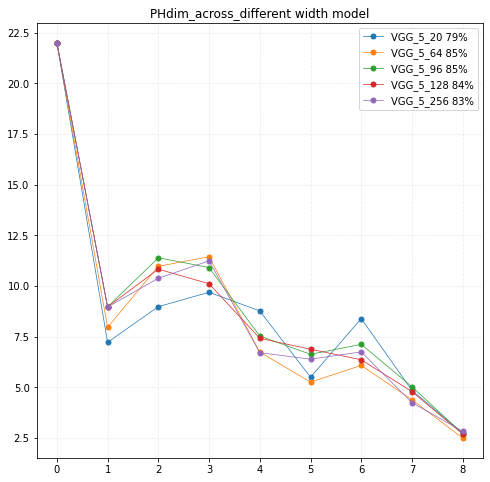

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
diff_width_model_dim = PHdim_models_diff_width
models_list_names = VGG_diff_width_names
for ID_model_manifold, name in zip(diff_width_model_dim, models_list_names):
  plt.plot(range(len(ID_model_manifold)), ID_model_manifold, 'o-',  linewidth=0.7, markersize=5, label=name)
ax.grid(which='major', color='#CCCCCC', linestyle='--', alpha=0.35)
plt.legend()
plt.title('PHdim_across_different width model')
plt.show()

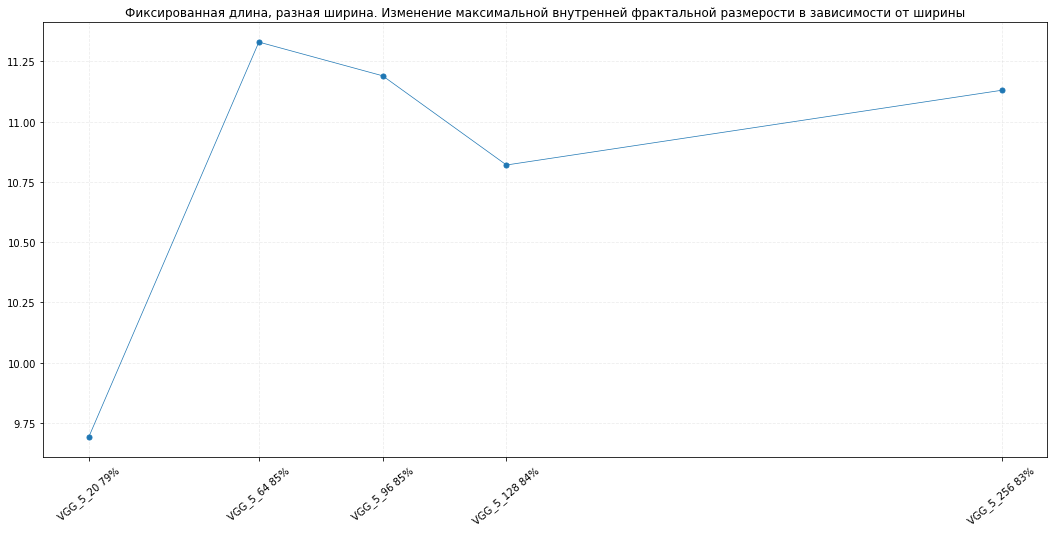

In [ ]:
n = 3
ID_layer = [id_l[n] for id_l in PHdim_models_diff_width]
ID_max = [max(id_l[1:]) for id_l in PHdim_models_diff_width]
depths = [20,64,96,128,256]
fig, ax = plt.subplots(figsize=(18, 8))
plt.plot(depths, ID_max, 'o-',  linewidth=0.7, markersize=5, label='depth vs id' )
ax.grid(which='major', color='#CCCCCC', linestyle='--', alpha=0.35)
ax.set_xticklabels(VGG_diff_width_names,rotation=40)
plt.xticks(depths)
plt.title('Фиксированная длина, разная ширина. Изменение максимальной внутренней фрактальной размерости в зависимости от ширины')
plt.show()

# Загрузка моделей

In [ ]:
Resnet_6_128 = keras.models.load_model('/content/drive/MyDrive/ML_materials/resnet/Resnet_6_128_0.87.h5') 
Resnet_6_96 = keras.models.load_model('/content/drive/MyDrive/ML_materials/Resnet_type_96/Resnet96_0.858.h5') 
Resnet_6_64 = keras.models.load_model('/content/drive/MyDrive/ML_materials/Resnet_type_96/Resnet_6_64_0.858.h5') 
Resnet_6_32 = keras.models.load_model('/content/drive/MyDrive/ML_materials/Resnet_type_96/Resnet_6_32_0.77.h5') 
Resnet_6_20 = keras.models.load_model('/content/drive/MyDrive/ML_materials/Resnet_type_96/Resnet_6_20_0.71.h5') 
Resnet_6_256 = keras.models.load_model('/content/drive/MyDrive/ML_materials/Resnet_type_96/Resnet_6_256_0.88.h5') 
Resnet_6_352 = keras.models.load_model('/content/drive/MyDrive/ML_materials/Resnet_type_96/Resnet_6_352_0.88.h5') 
Resnet_6_412 = keras.models.load_model('/content/drive/MyDrive/ML_materials/Resnet_type_96/Resnet_6_412_0.88.h5') 
Resnet_6_512 = keras.models.load_model('/content/drive/MyDrive/ML_materials/Resnet_type_96/Resnet_6_512_0.89.h5') 

Resnet_diff_width = [Resnet_6_20,Resnet_6_32,Resnet_6_64,Resnet_6_96,Resnet_6_128,Resnet_6_256,Resnet_6_352,Resnet_6_412,Resnet_6_512]
Resnet_diff_width_names = ['Resnet_6_20 71%','Resnet_6_32 77%','Resnet_6_64 85%','Resnet_6_96 86%', 'Resnet_6_128 87%', 'Resnet_6_256 88%',
                           'Resnet_6_352 88%','Resnet_6_412 88%','Resnet_6_512 89%']

In [ ]:
VGG_5_20 = keras.models.load_model('/content/drive/MyDrive/ML_materials/VGG/5_20_0.795.h5') 
VGG_5_64 = keras.models.load_model('/content/drive/MyDrive/ML_materials/VGG/5_64_0.855.h5') 
VGG_5_96 = keras.models.load_model('/content/drive/MyDrive/ML_materials/VGG/5_96_0.855.h5') 
VGG_5_128 = keras.models.load_model('/content/drive/MyDrive/ML_materials/VGG/5_0.84.h5') 
VGG_5_256 = keras.models.load_model('/content/drive/MyDrive/ML_materials/VGG/5_256_0.834.h5')  
VGG_5_396 = keras.models.load_model('/content/drive/MyDrive/ML_materials/VGG/5_396_0.84.h5')  
VGG_5_512 = keras.models.load_model('/content/drive/MyDrive/ML_materials/VGG/5_512_0.81.h5')  

VGG_diff_width = [VGG_5_20,VGG_5_64,VGG_5_96,VGG_5_128,VGG_5_256,VGG_5_396,VGG_5_512]
VGG_diff_width_names = ['VGG_5_20 79%','VGG_5_64 85%','VGG_5_96 85%','VGG_5_128 84%', 'VGG_5_256 83%', 'VGG_5_396 84%',
                           'VGG_5_512 81%']